In [41]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool


# Data Preparation

In [42]:
# Common funtions 
def get_pearson_matrix(raw, channels=None): 
    if (channels != None):
      ch = channels
    else:
      ch = raw.ch_names[:20]
    pearson = {} 

    for c in ch: 
        pearson[c] = {} 
        pearson[c][c] = 1
        
    _ch = ch.copy()
    while(len(_ch) > 0):
        chl1 = _ch.pop(0) 
        for chl2 in _ch:
            raw1, _ = raw[chl1]
            raw2, _ = raw[chl2]

            pearson_c = stats.pearsonr(raw1.flatten(), raw2.flatten())

            pearson[chl1][chl2] = pearson_c[0]
            pearson[chl2][chl1] = pearson_c[0]
    return pearson 


def get_eeg_file(unique_id): 
  rootdir = "./edf"
  sub,  taks = unique_id.split('_')
  regex = re.compile('(.*{}.*{}.*edf$)'.format(sub, taks))

  for root, dirs, files in os.walk(rootdir):
    for file in files:
      if regex.match(file):
        return file

In [43]:
get_eeg_file("9003_RSEC")

'INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf'

In [317]:
df = pd.read_excel("Demographic_List.xlsx")

df.head(10)

,sub,Age,Gender,Study,count,session,Condition,task,Headset
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24
5,9006,52,M,INSPECDS,291,900601000,HC,RSEO,X24
6,9008,53,F,INSPECDS,291,900801000,HC,RSEC,X24
7,9008,53,F,INSPECDS,290,900801000,HC,RSEO,X24
8,9009,48,F,INSPECDS,292,900901000,HC,RSEC,X24
9,9009,48,F,INSPECDS,279,900901000,HC,RSEO,X24


In [64]:
df.groupby("Condition").count()

,sub,Age,Gender,Study,count,session,task,Headset
Condition,,,,,,,,
AD,52,52,52,52,52,52,52,52
HC,224,224,224,224,224,224,224,224
MCI,107,107,107,107,107,107,107,107


In [65]:
conditions = set(df["Condition"])
conditions

{'AD', 'HC', 'MCI'}

In [318]:
df["unique_id"] = df["sub"].astype(str) + "_" + df["task"]
df

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC
...,...,...,...,...,...,...,...,...,...,...
378,9807,59,F,INSPECDS,292,980701000,MCI,RSEO,X24,9807_RSEO
379,9809,77,M,INSPECDS,288,980901000,MCI,RSEC,X24,9809_RSEC
380,9809,77,M,INSPECDS,284,980901000,MCI,RSEO,X24,9809_RSEO
381,9812,75,M,INSPECDS,290,981211000,MCI,RSEC,X24,9812_RSEC


In [319]:
df["filename"] = df["unique_id"].apply(get_eeg_file)
df

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC,INSPEC.INIT.900601000.130217.115256.Signals.Ra...
...,...,...,...,...,...,...,...,...,...,...,...
378,9807,59,F,INSPECDS,292,980701000,MCI,RSEO,X24,9807_RSEO,INSPEC.INIT.980701000.070619.062930.Signals.Ra...
379,9809,77,M,INSPECDS,288,980901000,MCI,RSEC,X24,9809_RSEC,INSPEC.INIT.980901000.170719.150050.Signals.Ra...
380,9809,77,M,INSPECDS,284,980901000,MCI,RSEO,X24,9809_RSEO,INSPEC.INIT.980901000.170719.150050.Signals.Ra...
381,9812,75,M,INSPECDS,290,981211000,MCI,RSEC,X24,9812_RSEC,INSPEC.INIT.981211000.290819.083316.Signals.Ra...


In [320]:
df_AD = df[df["Condition"] == "AD"]
df_AD.head(5)

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
200,9202,83,F,INSPECDS,286,920201000,AD,RSEC,X24,9202_RSEC,INSPEC.INIT.920201000.140317.103730.Signals.Ra...
201,9202,83,F,INSPECDS,283,920201000,AD,RSEO,X24,9202_RSEO,INSPEC.INIT.920201000.140317.103730.Signals.Ra...
206,9205,90,M,INSPECDS,259,920501000,AD,RSEC,X24,9205_RSEC,INSPEC.INIT.920501000.280317.110637.Signals.Ra...
207,9205,90,M,INSPECDS,240,920501000,AD,RSEO,X24,9205_RSEO,INSPEC.INIT.920501000.280317.110637.Signals.Ra...
208,9206,59,F,INSPECDS,287,920601000,AD,RSEC,X24,9206_RSEC,INSPEC.INIT.920601000.050417.122248.Signals.Ra...


In [321]:
def get_raw_eeg(filename, root_dir = "./edf/"):
    raw = mne.io.read_raw_edf(root_dir + filename)
    return raw

In [ ]:
raw = mne.io.read_raw_edf(root_dir + filename)

In [322]:
df = df[df["Condition"] != "MCI"]

In [71]:
df.to_csv("dataframe.csv")

In [122]:
for _, s in df.iterrows():
    print(_)
    break

0


In [323]:
df[df["Condition"] == "AD"]

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
200,9202,83,F,INSPECDS,286,920201000,AD,RSEC,X24,9202_RSEC,INSPEC.INIT.920201000.140317.103730.Signals.Ra...
201,9202,83,F,INSPECDS,283,920201000,AD,RSEO,X24,9202_RSEO,INSPEC.INIT.920201000.140317.103730.Signals.Ra...
206,9205,90,M,INSPECDS,259,920501000,AD,RSEC,X24,9205_RSEC,INSPEC.INIT.920501000.280317.110637.Signals.Ra...
207,9205,90,M,INSPECDS,240,920501000,AD,RSEO,X24,9205_RSEO,INSPEC.INIT.920501000.280317.110637.Signals.Ra...
208,9206,59,F,INSPECDS,287,920601000,AD,RSEC,X24,9206_RSEC,INSPEC.INIT.920601000.050417.122248.Signals.Ra...
209,9206,59,F,INSPECDS,290,920601000,AD,RSEO,X24,9206_RSEO,INSPEC.INIT.920601000.050417.122248.Signals.Ra...
214,9210,68,F,INSPECDS,248,921001000,AD,RSEC,X24,9210_RSEC,INSPEC.INIT.921001000.030517.150702.Signals.Ra...
215,9210,68,F,INSPECDS,282,921001000,AD,RSEO,X24,9210_RSEO,INSPEC.INIT.921001000.030517.145711.Signals.Ra...
216,9211,77,M,INSPECDS,271,921101000,AD,RSEC,X24,9211_RSEC,INSPEC.INIT.921101000.090517.115805.Signals.Ra...
217,9211,77,M,INSPECDS,286,921101000,AD,RSEO,X24,9211_RSEO,INSPEC.INIT.921101000.090517.115805.Signals.Ra...


In [72]:
# Read EEG raw files and save them in a dict for later use 
raw_files = {} 
eeg_min_size = 308224
for _, s in df.iterrows(): 
    raw_files[s["unique_id"]] = get_raw_eeg(s["filename"])
    shape = raw_files[s["unique_id"]].get_data().shape[1] 
    eeg_min_size = shape if shape < eeg_min_size else eeg_min_size

eeg_min_size

Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEO_01.edited.47.187.347.192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEC_01.edited.25.108.325.112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEO_01.edited.347.72.647.76.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\C

285696

In [161]:
eeg_max_size = 1024
n_features = 20
n_samples = len(raw_files) 
channels = raw_files["9003_RSEC"].ch_names[:20]


In [277]:
raw_files["9273_RSEO"].get_data(channels).shape #9273_RSEO

(20, 308224)

In [228]:
patient_hc = np.array(split_given_size(raw_files["9003_RSEC"].get_data(channels), 1024))


In [364]:
patient_hc = np.array(split_given_size(raw_files["9003_RSEC"].get_data(channels), 1024*60))

patient_hc = torch.tensor(patient_hc)
hc_corr = []

for i in range(patient_hc.shape[0]):
    corr= torch.corrcoef(patient_hc[i])
    hc_corr.append(corr.numpy()) 
hc_corr = np.array(hc_corr)

In [365]:
patient_hc = np.array(split_given_size(raw_files["9273_RSEO"].get_data(channels), (1024*60)))

patient_hc = torch.tensor(patient_hc)
ad_corr = []

for i in range(patient_hc.shape[0]):
    corr= torch.corrcoef(patient_hc[i])
    ad_corr.append(corr.numpy()) 
ad_corr = np.array(ad_corr)

<AxesSubplot:>

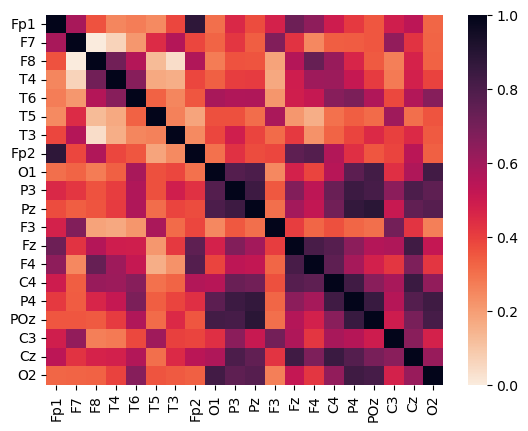

In [366]:
sns.heatmap(np.average(ad_corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

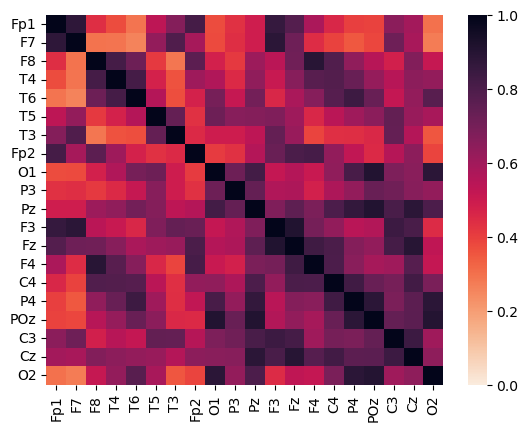

In [367]:
sns.heatmap(np.average(hc_corr, axis=0), cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

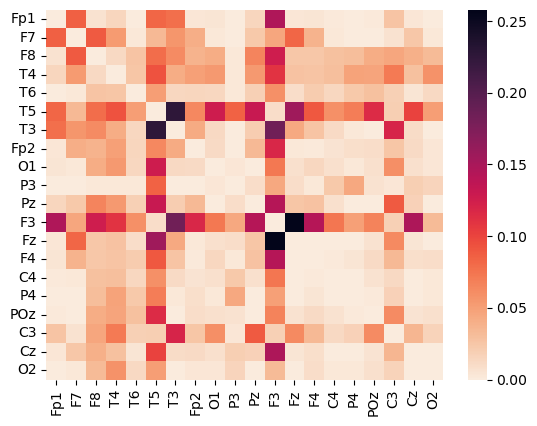

In [368]:
sns.heatmap((np.average(ad_corr, axis=0) - np.average(hc_corr, axis=0))**2, cmap=cmap, vmin=0, xticklabels=channels, yticklabels=channels)

In [315]:
def split_given_size(a, size):
    new_array =  np.array_split(a, np.arange(size,a.shape[1],size), axis=1)
    if(new_array[-1].shape[1] < new_array[0].shape[1]):
        new_array = new_array[:-1]
    return new_array
    
#split_given_size(np.arange(1000),7)

In [324]:
new_df = []
X = np.zeros((n_samples, n_features, eeg_max_size))
X.shape
# Fill matrix X with data 
for i, s in df.iterrows(): 
    raw = raw_files[s["unique_id"]]
    shape = raw.get_data().shape[1]
    data = raw.get_data(channels) 
    #data = np.pad(data, [(0,0),(0, eeg_max_size-shape )], 'wrap')
    #print(data.shape)
    data = split_given_size(data, 1024*60)
    #print(len(data))
    for i, d in enumerate(data): 
        raw = torch.Tensor(d)
        corr = torch.corrcoef(raw)
        object = {
            "UID" : s["unique_id"] + "_{}".format(i), 
            "Condition" : s["Condition"],
            "Correlation" : corr.numpy()
        }
        new_df.append(object)

In [325]:
new_df = pd.DataFrame(new_df)
new_df.head()

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.90661967, 0.72530466, 0.38593653, 0.1..."
1,9003_RSEC_1,HC,"[[1.0, 0.87269574, 0.6468242, 0.5850507, 0.407..."
2,9003_RSEC_2,HC,"[[1.0, 0.8655385, 0.08705698, 0.06501593, 0.11..."
3,9003_RSEC_3,HC,"[[1.0, 0.8236727, -0.031504884, 0.08421207, 0...."
4,9003_RSEC_4,HC,"[[1.0, 0.91261464, 0.7787058, 0.74198246, 0.70..."


In [344]:
new_df.to_pickle("corr_dataset.pkl")

In [375]:
pd.read_pickle("corr_dataset.pkl")

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.90661967, 0.72530466, 0.38593653, 0.1..."
1,9003_RSEC_1,HC,"[[1.0, 0.87269574, 0.6468242, 0.5850507, 0.407..."
2,9003_RSEC_2,HC,"[[1.0, 0.8655385, 0.08705698, 0.06501593, 0.11..."
3,9003_RSEC_3,HC,"[[1.0, 0.8236727, -0.031504884, 0.08421207, 0...."
4,9003_RSEC_4,HC,"[[1.0, 0.91261464, 0.7787058, 0.74198246, 0.70..."
...,...,...,...
1374,9632_RSEO_0,HC,"[[1.0, 0.77053493, 0.48634723, 0.15535177, 0.2..."
1375,9632_RSEO_1,HC,"[[1.0, 0.75288874, 0.48128098, 0.072755516, 0...."
1376,9632_RSEO_2,HC,"[[1.0, 0.7390504, 0.4988018, 0.0011451734, 0.1..."
1377,9632_RSEO_3,HC,"[[0.99999994, 0.76898086, 0.529885, -0.0393959..."


In [76]:
np.save('samples', X)

In [77]:
# Calculate and store Correlations 
from nancorrmp.nancorrmp import NaNCorrMp
X_corr = np.zeros((X.shape[0], X.shape[1], X.shape[1] ))
p_corr = np.zeros(X_corr.shape)

for i in range(X.shape[0]):
    corr, p = NaNCorrMp.calculate_with_p_value(X[i],  n_jobs=5)
    X_corr[i] += corr
    p_corr[i] += p

In [78]:
X_corr.shape

(276, 20, 20)

In [345]:
hc_idx = list(np.where(new_df["Condition"] == "HC")[0])
ad_idx = list(np.where(new_df["Condition"] == "AD")[0])
corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))

In [354]:
new_df.loc[1]["Correlation"]

array([[1.        , 0.87269574, 0.6468242 , 0.5850507 , 0.40707794,
        0.6024354 , 0.6905224 , 0.9173564 , 0.44408986, 0.49624932,
        0.5822179 , 0.84383875, 0.8208445 , 0.68700063, 0.59016776,
        0.53388816, 0.47691867, 0.6662729 , 0.7029726 , 0.3904568 ],
       [0.8726958 , 1.        , 0.5278846 , 0.5380019 , 0.3671787 ,
        0.65947175, 0.77184665, 0.7400088 , 0.42738444, 0.60531116,
        0.61358   , 0.90314686, 0.799243  , 0.6412298 , 0.54615635,
        0.47003815, 0.49576506, 0.7665638 , 0.7116268 , 0.3439718 ],
       [0.6468242 , 0.5278846 , 1.        , 0.8191364 , 0.67826295,
        0.48230684, 0.40408325, 0.7994977 , 0.41957602, 0.432356  ,
        0.6200182 , 0.6385531 , 0.7297106 , 0.86845356, 0.7714231 ,
        0.5916607 , 0.48978728, 0.46972123, 0.68644863, 0.46646833],
       [0.5850507 , 0.5380019 , 0.8191364 , 1.        , 0.75739473,
        0.467185  , 0.44627893, 0.67366344, 0.50471085, 0.5455477 ,
        0.65341127, 0.6016231 , 0.6934183 , 0

In [355]:
for i in hc_idx: 
    corr_hc += new_df.loc[i]["Correlation"]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += new_df.loc[i]["Correlation"]

corr_ad = corr_ad/len(ad_idx)

<AxesSubplot:>

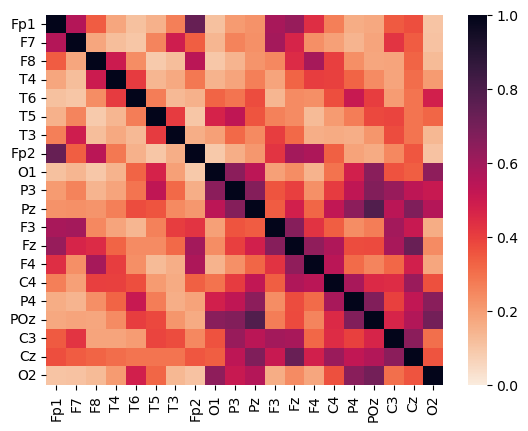

In [373]:
%matplotlib inline

cmap = sns.cm.rocket_r

sns.heatmap(corr_hc**2, cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

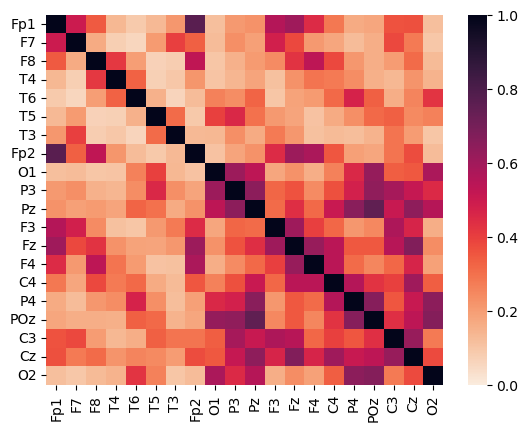

In [372]:
sns.heatmap(corr_ad**2, cmap=cmap, vmax=1, vmin=0, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

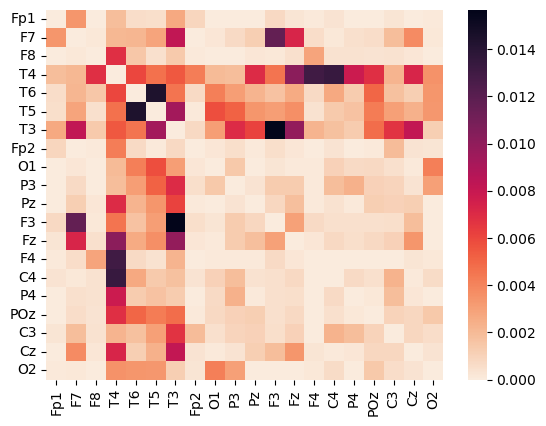

In [374]:
sns.heatmap((corr_hc**2-corr_ad**2)**2, cmap=cmap, xticklabels=channels, yticklabels=channels)

In [34]:
np.save('samples_corr', X_corr)
np.save('p_values', p_corr)

# Paper Dataset